# Métricas de Cobertura Temporal

Este notebook calcula las métricas de cobertura temporal de los keyframes seleccionados.

**Objetivo:**
- Calcular cobertura porcentual del video cubierto por keyframes
- Analizar gaps temporales (intervalos sin keyframes)
- Analizar distribución temporal de keyframes a lo largo del video

**Métricas calculadas:**
- Coverage percentage: Porcentaje del video cubierto
- Mean gap, Max gap, Min gap: Estadísticas de gaps temporales
- Time span covered vs total: Tiempo cubierto vs tiempo total


In [2]:
import sys
import os
from pathlib import Path
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configurar paths
project_root = Path("/Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador")
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / "src"))

# Importar evaluador
from src.app.utils.evaluator import PipelineEvaluator

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Intervalo entre frames en segundos (según el pipeline)
FRAME_INTERVAL_SEC = 2.0


## 1. Cargar Datos


In [3]:
# Cargar dataset de videos filtrados
dataset_path = project_root / "src" / "notebooks" / "datasets" / "df_videos_frames_filtrados_v2.csv"
df_videos = pd.read_csv(dataset_path)

print(f"✅ Dataset cargado: {len(df_videos)} videos")
print(f"\n📊 Columnas disponibles: {list(df_videos.columns)}")


✅ Dataset cargado: 1133 videos

📊 Columnas disponibles: ['video_id', 'channel', 'video_date', 'video_filename', 'duration', 'n_frames', 'frame_paths', 'n_frames_filtrado', 'n_frames_original', 'reduction_percentage']


## 2. Cargar Keyframes Seleccionados

Nota: Necesitamos los keyframes seleccionados. Si no están guardados, podemos calcularlos desde los notebooks de clustering o usar el método de extracción de keyframes.


In [4]:
# Cargar keyframes desde resultados guardados (si existen)
# Si no existen, calcularlos desde features usando KeyFrameSelector o cosine_similarity

from src.app.utils.keyframe_selector import KeyFrameSelector
from src.app.utils.feature_extractor import FeatureExtractor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import json

# Configuración del método (empezar con cosine_similarity que es más rápido)
METHOD = 'kmeans'  # Opciones: 'cosine_similarity' o 'kmeans'
THRESHOLD = 0.95  # Threshold para cosine_similarity (0.90 o 0.95)

# Inicializar selector de keyframes solo para kmeans
if METHOD == 'kmeans':
    keyframe_selector = KeyFrameSelector(
        distance_metric='euclidean',
        normalize_features=False,
        clustering_method='kmeans'
    )

# Función para extraer keyframes usando cosine similarity (no es clustering)
def extract_keyframes_cosine_similarity(features, frame_paths, threshold=0.95):
    """
    Extrae keyframes usando cosine similarity según el método del artículo.
    
    Algoritmo:
    1. El primer frame siempre se selecciona
    2. Calcular cosine similarity entre frames consecutivos
    3. Si similitud < threshold δ, seleccionar frame como keyframe
    
    Args:
        features: Array numpy con features (n_frames, n_features)
        frame_paths: Lista de rutas de frames
        threshold: Threshold δ para selección (0.90 o 0.95)
    
    Returns:
        Lista de paths de keyframes
    """
    if len(features) == 0 or len(frame_paths) == 0:
        return []
    
    # Normalizar features para cosine similarity
    features_norm = normalize(features, norm='l2')
    
    # El primer frame siempre se selecciona
    keyframes = [frame_paths[0]]
    
    # Calcular cosine similarity entre frames consecutivos
    for i in range(len(features_norm) - 1):
        # Calcular cosine similarity entre frame i e i+1
        similarity = cosine_similarity(
            features_norm[i].reshape(1, -1),
            features_norm[i+1].reshape(1, -1)
        )[0][0]
        
        # Si similitud < threshold, seleccionar frame i+1 como keyframe
        if similarity < threshold:
            keyframes.append(frame_paths[i+1])
    
    return keyframes

# Inicializar extractor de features (para cargar features si es necesario)
feature_extractor = FeatureExtractor(model_name='resnet50', device='cpu', batch_size=32)

# Directorios
keyframes_dir = project_root / "src" / "notebooks" / "keyframes"
features_dir = project_root / "src" / "notebooks" / "features_resnet50"

# Crear directorio de keyframes si no existe
keyframes_dir.mkdir(parents=True, exist_ok=True)

def load_keyframes_for_video(video_id, method='kmeans'):
    """
    Carga keyframes guardados para un video desde archivo JSON.
    
    Args:
        video_id: ID del video
        method: Método usado ('kmeans' o 'cosine_similarity')
    
    Returns:
        list: Lista de paths de keyframes, o None si no se encuentran
    """
    keyframes_json = keyframes_dir / f"{video_id}_keyframes_{method}.json"
    
    if keyframes_json.exists():
        try:
            with open(keyframes_json, 'r') as f:
                data = json.load(f)
                keyframes = data.get('keyframes', [])
            return keyframes
        except Exception as e:
            print(f"   ⚠️  Error cargando keyframes para {video_id}: {e}")
            return None
    
    return None

def save_keyframes_for_video(video_id, keyframes, method='kmeans'):
    """
    Guarda keyframes para un video en formato JSON.
    
    Args:
        video_id: ID del video
        keyframes: Lista de paths de keyframes
        method: Método usado ('kmeans' o 'cosine_similarity')
    """
    keyframes_json = keyframes_dir / f"{video_id}_keyframes_{method}.json"
    
    try:
        data = {
            'video_id': video_id,
            'method': method,
            'n_keyframes': len(keyframes),
            'keyframes': keyframes
        }
        with open(keyframes_json, 'w') as f:
            json.dump(data, f, indent=2)
    except Exception as e:
        print(f"   ⚠️  Error guardando keyframes para {video_id}: {e}")

print("📝 Preparando estructura para cálculo de métricas...")
print("💡 Nota: Si no hay keyframes guardados, se calcularán desde los features disponibles")
print(f"📁 Directorio de keyframes: {keyframes_dir}")
print(f"📄 Formato: JSON (legible y portable)")


Cargando RESNET50 en cpu...
Modelo RESNET50 cargado exitosamente
Dimensión de features: 2048
📝 Preparando estructura para cálculo de métricas...
💡 Nota: Si no hay keyframes guardados, se calcularán desde los features disponibles
📁 Directorio de keyframes: /Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador/src/notebooks/keyframes
📄 Formato: JSON (legible y portable)


## 3. Calcular Métricas de Cobertura Temporal


In [5]:
# Inicializar evaluador
evaluator = PipelineEvaluator()

# Lista para almacenar métricas de todos los videos
temporal_metrics = []

# Directorio de features
features_dir = project_root / "src" / "notebooks" / "features_resnet50"

print("🔄 Calculando métricas de cobertura temporal...")
print(f"💡 Método configurado: {METHOD}")
if METHOD == 'cosine_similarity':
    print(f"💡 Threshold configurado: {THRESHOLD}")
print(f"💡 Buscando keyframes guardados del método '{METHOD}'...")
print(f"💡 Si no se encuentran, se calcularán desde features usando '{METHOD}'")

for idx, row in tqdm(df_videos.iterrows(), total=len(df_videos), desc="Procesando videos"):
    try:
        video_id = row['video_id']
        
        # Obtener lista de frames filtrados
        frame_paths_str = row['frame_paths']
        if isinstance(frame_paths_str, str):
            all_frame_paths = ast.literal_eval(frame_paths_str)
        else:
            all_frame_paths = frame_paths_str
        
        if len(all_frame_paths) == 0:
            continue
        
        # Intentar cargar keyframes guardados o calcularlos
        keyframe_paths = None
        method_used = None  # Para identificar qué método se usó
        
        # Buscar keyframes guardados SOLO del método configurado
        # Si el método configurado es kmeans, solo busca kmeans guardados
        # Si el método configurado es cosine_similarity, solo busca cosine_similarity guardados
        keyframe_paths = load_keyframes_for_video(video_id, method=METHOD)
        if keyframe_paths is not None:
            method_used = METHOD
        
        # Si no se encontraron guardados del método configurado, calcular desde features
        if keyframe_paths is None:
            method_used = METHOD
            features_path = features_dir / f"{video_id}_features.pkl"
            if features_path.exists():
                # Cargar features
                features, valid_paths, metadata = feature_extractor.load_features(str(features_path))
                
                if len(features) > 0 and len(valid_paths) > 0:
                    # Calcular keyframes usando el método configurado
                    try:
                        if METHOD == 'cosine_similarity':
                            # Usar función directa de cosine similarity (no clustering)
                            keyframe_paths = extract_keyframes_cosine_similarity(
                                features,
                                valid_paths,
                                threshold=THRESHOLD
                            )
                        else:  # kmeans
                            # Usar KeyFrameSelector con clustering
                            keyframes, labels, model, stats = keyframe_selector.select_keyframes(
                                features,
                                valid_paths,
                                n_frames=len(valid_paths)
                            )
                            keyframe_paths = keyframes
                        
                        # Guardar keyframes calculados en JSON para uso futuro
                        save_keyframes_for_video(video_id, keyframe_paths, method=METHOD)
                        # Mostrar progreso cada 100 videos
                        if idx % 100 == 0:
                            print(f"   💾 Calculando keyframes con {METHOD}... ({idx}/{len(df_videos)})")
                    except Exception as e:
                        print(f"⚠️  Error calculando keyframes para {video_id}: {e}")
                        continue
        
        # Si tenemos keyframes, calcular métricas de cobertura temporal
        if keyframe_paths and len(keyframe_paths) > 0:
            metrics = evaluator.calculate_temporal_coverage(
                keyframe_paths,
                all_frame_paths,
                frame_interval_sec=FRAME_INTERVAL_SEC
            )
            
            # Agregar información del método usado y metadata
            metrics['video_id'] = video_id
            metrics['channel'] = row.get('channel', '')
            metrics['duration'] = row.get('duration', 0)
            metrics['n_total_frames'] = len(all_frame_paths)
            metrics['n_keyframes'] = len(keyframe_paths)
            metrics['method'] = method_used  # Método usado para extraer keyframes
            if method_used == 'cosine_similarity':
                metrics['threshold'] = THRESHOLD  # Threshold usado para cosine_similarity
            
            temporal_metrics.append(metrics)
        
    except Exception as e:
        print(f"⚠️  Error procesando video {video_id}: {e}")
        continue

print(f"\n✅ Métricas calculadas para {len(temporal_metrics)} videos")


🔄 Calculando métricas de cobertura temporal...
💡 Método configurado: kmeans
💡 Buscando keyframes guardados del método 'kmeans'...
💡 Si no se encuentran, se calcularán desde features usando 'kmeans'


Procesando videos:  89%|████████▉ | 1007/1133 [00:00<00:00, 1543.78it/s]

⚠️  Error calculando keyframes para uRnB41tY8RA: index 1 is out of bounds for axis 0 with size 1
⚠️  Error calculando keyframes para bZ2foia0QnE: index 1 is out of bounds for axis 0 with size 1


Procesando videos: 100%|██████████| 1133/1133 [00:00<00:00, 1286.85it/s]


✅ Métricas calculadas para 1131 videos


## 4. Análisis y Visualización de Métricas


📊 ESTADÍSTICAS DE COBERTURA TEMPORAL

Cobertura Porcentual:
  • Media: 4.73%
  • Mediana: 2.91%
  • Mínimo: 0.86%
  • Máximo: 100.00%
  • Desviación estándar: 7.40%

Gaps Temporales (segundos):
  • Media: 71.41s
  • Mediana: 62.80s
  • Mínimo: 0.00s
  • Máximo: 686.00s

✅ Métricas guardadas en: /Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador/src/notebooks/datasets/metricas_cobertura_temporal_kmeans.csv
📊 Método usado: kmeans

📈 MÉTRICAS POR MÉTODO:

   Método: kmeans
   • Videos: 1131
   • Cobertura promedio: 4.73%
   • Gap medio promedio: 71.41s
   • Keyframes promedio: 6.0
✅ Visualización guardada en: /Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador/src/notebooks/images/cobertura_temporal_kmeans.png


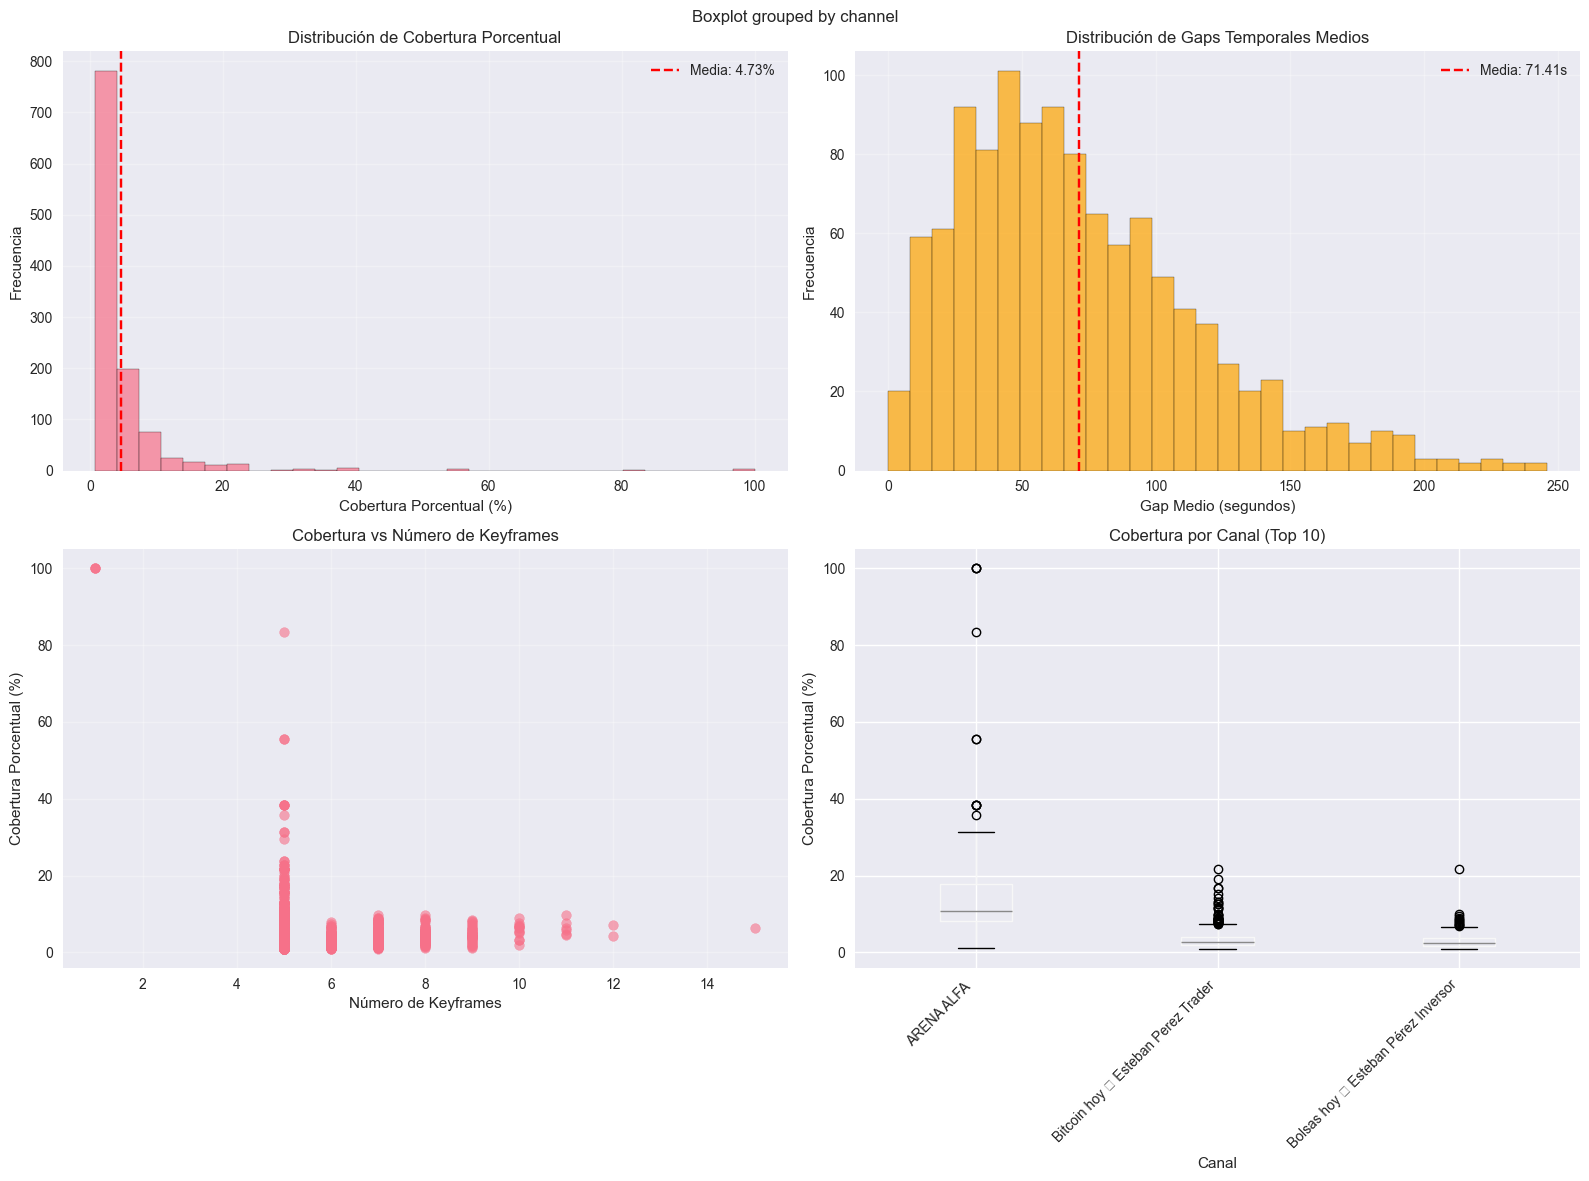

In [6]:
if len(temporal_metrics) > 0:
    # Crear DataFrame con métricas
    df_metrics = pd.DataFrame(temporal_metrics)
    
    # Estadísticas generales
    print("📊 ESTADÍSTICAS DE COBERTURA TEMPORAL")
    print("=" * 60)
    print(f"\nCobertura Porcentual:")
    print(f"  • Media: {df_metrics['coverage_percentage'].mean():.2f}%")
    print(f"  • Mediana: {df_metrics['coverage_percentage'].median():.2f}%")
    print(f"  • Mínimo: {df_metrics['coverage_percentage'].min():.2f}%")
    print(f"  • Máximo: {df_metrics['coverage_percentage'].max():.2f}%")
    print(f"  • Desviación estándar: {df_metrics['coverage_percentage'].std():.2f}%")
    
    print(f"\nGaps Temporales (segundos):")
    print(f"  • Media: {df_metrics['mean_gap'].mean():.2f}s")
    print(f"  • Mediana: {df_metrics['mean_gap'].median():.2f}s")
    print(f"  • Mínimo: {df_metrics['min_gap'].min():.2f}s")
    print(f"  • Máximo: {df_metrics['max_gap'].max():.2f}s")
    
    # Determinar el método usado para el nombre del archivo
    method_suffix = METHOD
    if METHOD == 'cosine_similarity':
        method_suffix = f"{METHOD}_threshold{THRESHOLD}"
    
    # Guardar resultados con el método en el nombre del archivo
    output_path = project_root / "src" / "notebooks" / "datasets" / f"metricas_cobertura_temporal_{method_suffix}.csv"
    df_metrics.to_csv(output_path, index=False)
    print(f"\n✅ Métricas guardadas en: {output_path}")
    print(f"📊 Método usado: {METHOD}")
    if METHOD == 'cosine_similarity':
        print(f"📊 Threshold: {THRESHOLD}")
    
    # Mostrar estadísticas por método si hay múltiples métodos en los datos
    if 'method' in df_metrics.columns:
        print(f"\n📈 MÉTRICAS POR MÉTODO:")
        print("=" * 60)
        for method in sorted(df_metrics['method'].unique()):
            method_data = df_metrics[df_metrics['method'] == method]
            print(f"\n   Método: {method}")
            if method == 'cosine_similarity' and 'threshold' in method_data.columns:
                threshold_val = method_data['threshold'].iloc[0] if len(method_data) > 0 else 'N/A'
                print(f"   Threshold: {threshold_val}")
            print(f"   • Videos: {len(method_data)}")
            print(f"   • Cobertura promedio: {method_data['coverage_percentage'].mean():.2f}%")
            print(f"   • Gap medio promedio: {method_data['mean_gap'].mean():.2f}s")
            print(f"   • Keyframes promedio: {method_data['n_keyframes'].mean():.1f}")
    
    # Visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Distribución de cobertura porcentual
    axes[0, 0].hist(df_metrics['coverage_percentage'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(df_metrics['coverage_percentage'].mean(), color='red', linestyle='--', 
                       label=f'Media: {df_metrics["coverage_percentage"].mean():.2f}%')
    axes[0, 0].set_xlabel('Cobertura Porcentual (%)')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].set_title('Distribución de Cobertura Porcentual')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Distribución de gaps medios
    axes[0, 1].hist(df_metrics['mean_gap'], bins=30, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].axvline(df_metrics['mean_gap'].mean(), color='red', linestyle='--',
                       label=f'Media: {df_metrics["mean_gap"].mean():.2f}s')
    axes[0, 1].set_xlabel('Gap Medio (segundos)')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].set_title('Distribución de Gaps Temporales Medios')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Cobertura vs Número de keyframes
    axes[1, 0].scatter(df_metrics['n_keyframes'], df_metrics['coverage_percentage'], alpha=0.6)
    axes[1, 0].set_xlabel('Número de Keyframes')
    axes[1, 0].set_ylabel('Cobertura Porcentual (%)')
    axes[1, 0].set_title('Cobertura vs Número de Keyframes')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Boxplot de cobertura por canal
    if 'channel' in df_metrics.columns:
        channels = df_metrics['channel'].value_counts().head(10).index
        df_top_channels = df_metrics[df_metrics['channel'].isin(channels)]
        df_top_channels.boxplot(column='coverage_percentage', by='channel', ax=axes[1, 1])
        axes[1, 1].set_xlabel('Canal')
        axes[1, 1].set_ylabel('Cobertura Porcentual (%)')
        axes[1, 1].set_title('Cobertura por Canal (Top 10)')
        plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Guardar visualización con el método en el nombre del archivo
    output_img = project_root / "src" / "notebooks" / "images" / f"cobertura_temporal_{method_suffix}.png"
    output_img.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_img, dpi=300, bbox_inches='tight')
    print(f"✅ Visualización guardada en: {output_img}")
    
    plt.show()
    
    # Si hay múltiples métodos en los datos, crear comparación
    if 'method' in df_metrics.columns and len(df_metrics['method'].unique()) > 1:
        print(f"\n📊 Creando comparación entre métodos...")
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Comparación de cobertura por método
        for method in df_metrics['method'].unique():
            method_data = df_metrics[df_metrics['method'] == method]
            label = method
            if method == 'cosine_similarity' and 'threshold' in method_data.columns:
                threshold_val = method_data['threshold'].iloc[0] if len(method_data) > 0 else ''
                label = f"{method} (δ={threshold_val})"
            axes[0].hist(method_data['coverage_percentage'], bins=30, alpha=0.6, label=label)
        axes[0].set_xlabel('Cobertura Porcentual (%)')
        axes[0].set_ylabel('Frecuencia')
        axes[0].set_title('Distribución de Cobertura por Método')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Comparación de gaps por método
        for method in df_metrics['method'].unique():
            method_data = df_metrics[df_metrics['method'] == method]
            label = method
            if method == 'cosine_similarity' and 'threshold' in method_data.columns:
                threshold_val = method_data['threshold'].iloc[0] if len(method_data) > 0 else ''
                label = f"{method} (δ={threshold_val})"
            axes[1].hist(method_data['mean_gap'], bins=30, alpha=0.6, label=label)
        axes[1].set_xlabel('Gap Medio (segundos)')
        axes[1].set_ylabel('Frecuencia')
        axes[1].set_title('Distribución de Gaps por Método')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        comparison_img = project_root / "src" / "notebooks" / "images" / "cobertura_temporal_comparacion_metodos.png"
        plt.savefig(comparison_img, dpi=300, bbox_inches='tight')
        print(f"✅ Comparación de métodos guardada en: {comparison_img}")
        plt.show()
else:
    print("⚠️  No hay métricas calculadas. Necesitas cargar los keyframes seleccionados primero.")


## 5. Comparación de Métodos

Comparación de métricas de cobertura temporal entre los dos métodos: K-Means y Cosine Similarity.


✅ Métricas cargadas:
   • K-Means: 1131 videos
   • Cosine Similarity: 1133 videos

📊 COMPARACIÓN DE MÉTODOS

K-Means:
  • Cobertura:
    - Media: 4.73%
    - Mediana: 2.91%
    - Desv. Estándar: 7.40%
  • Gap medio:
    - Media: 71.41s
    - Mediana: 62.80s
    - Desv. Estándar: 44.89s
  • Keyframes:
    - Media: 6.0
    - Mediana: 5.0
    - Desv. Estándar: 1.3
  • Max gap: 686.00s
  • Min gap: 0.00s

Cosine Similarity (δ=0.95):
  • Cobertura:
    - Media: 44.83%
    - Mediana: 40.00%
    - Desv. Estándar: 19.68%
  • Gap medio:
    - Media: 5.37s
    - Mediana: 4.90s
    - Desv. Estándar: 2.75s
  • Keyframes:
    - Media: 93.8
    - Mediana: 77.0
    - Desv. Estándar: 69.0
  • Max gap: 164.00s
  • Min gap: 0.00s

✅ Comparación completa guardada en: /Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador/src/notebooks/images/cobertura_temporal_comparacion_completa.png


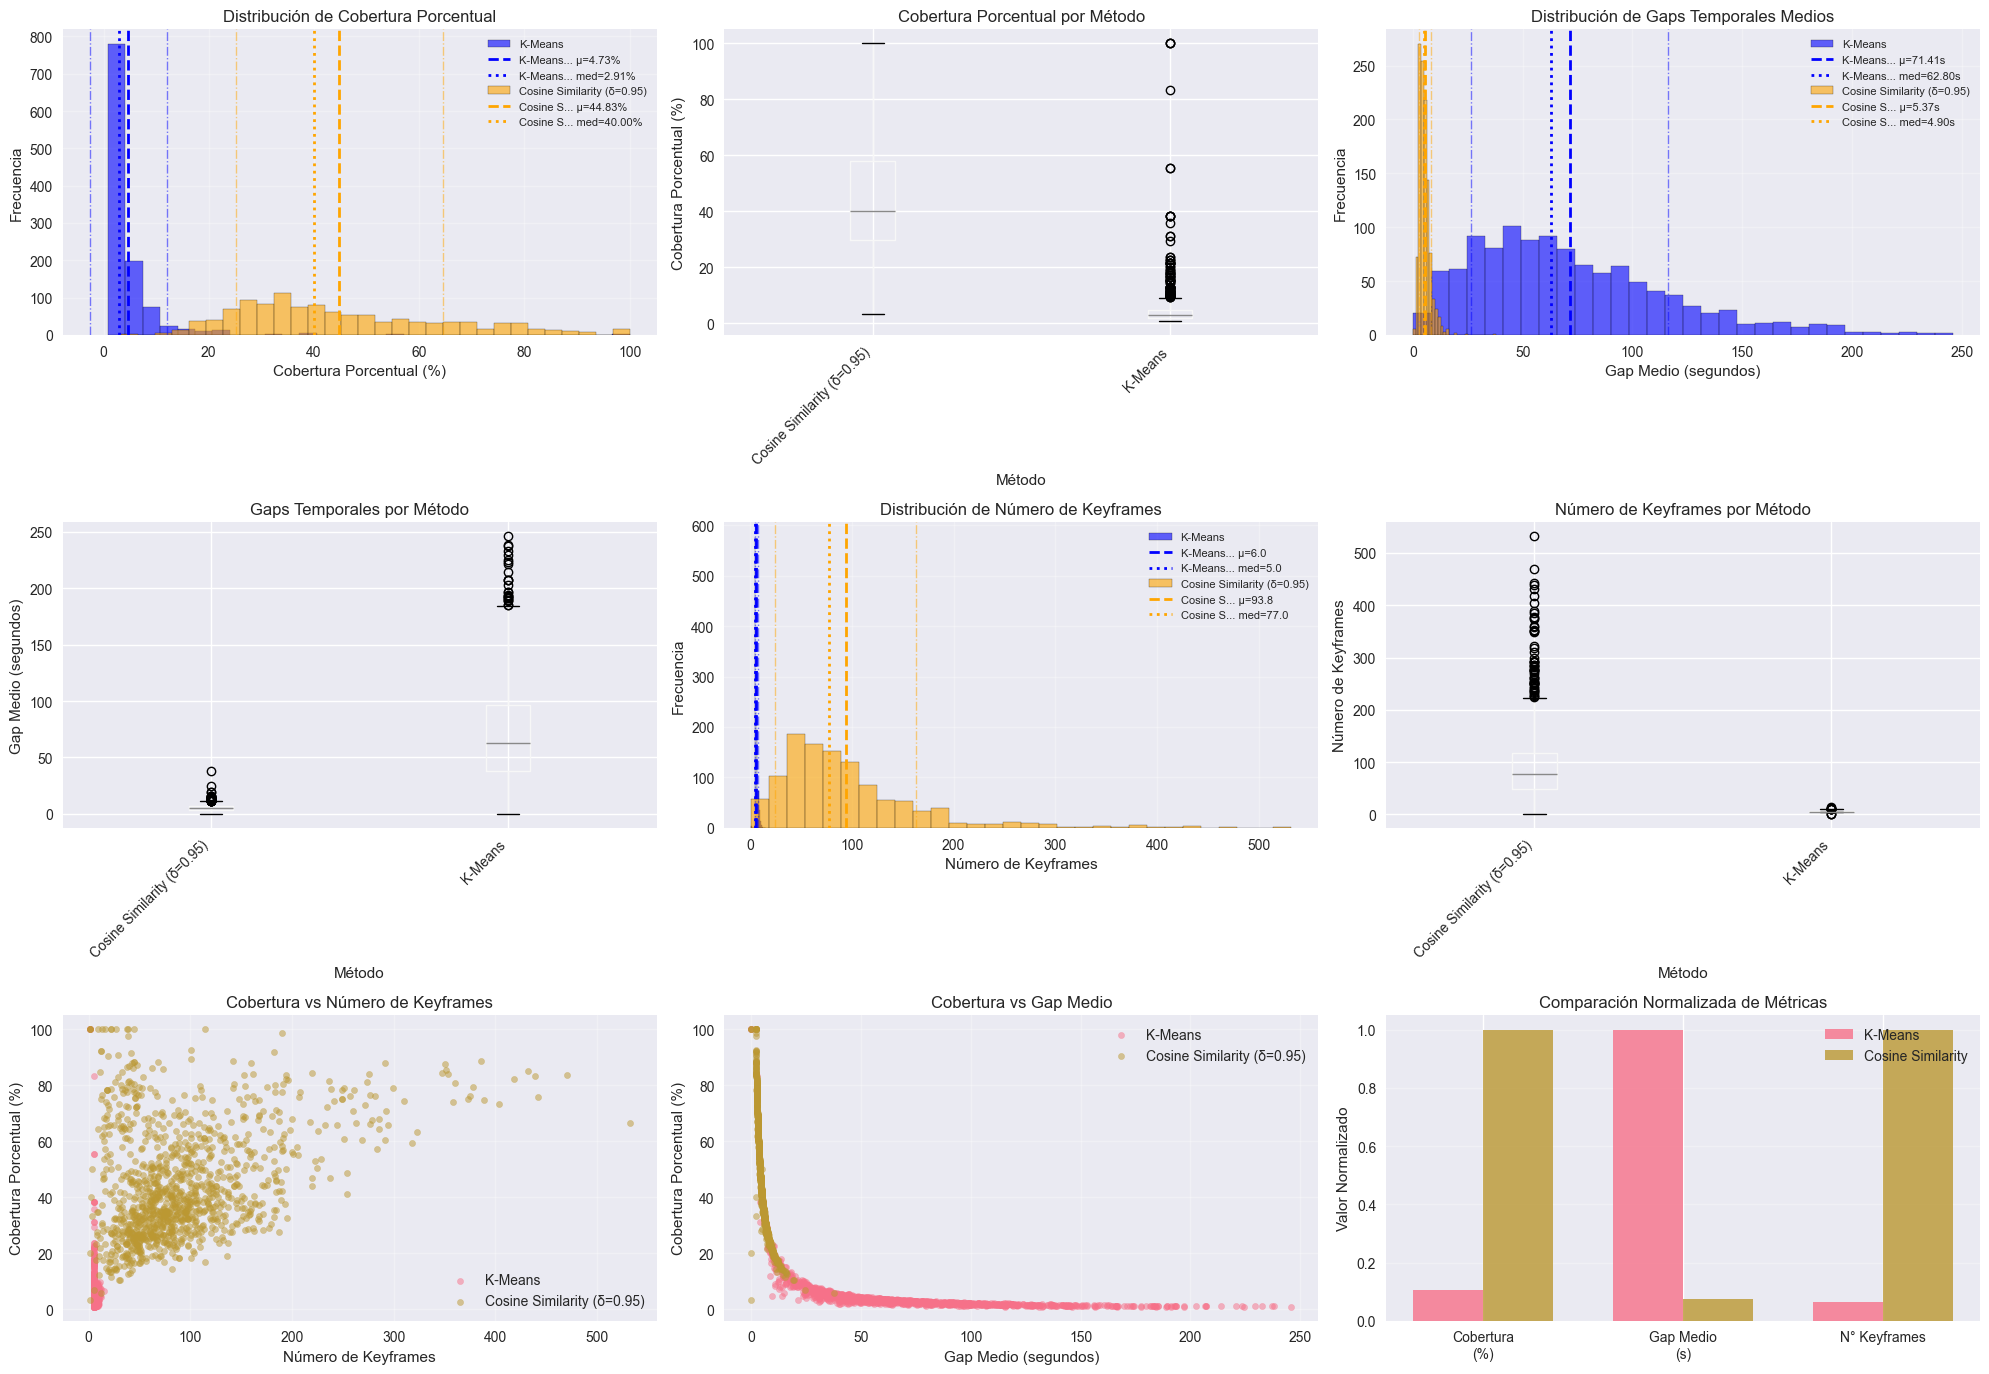

✅ Comparación boxplot guardada en: /Users/andrestrepo/Documents/repos_personal/proyecto-vision-computador/src/notebooks/images/cobertura_temporal_comparacion_boxplot.png


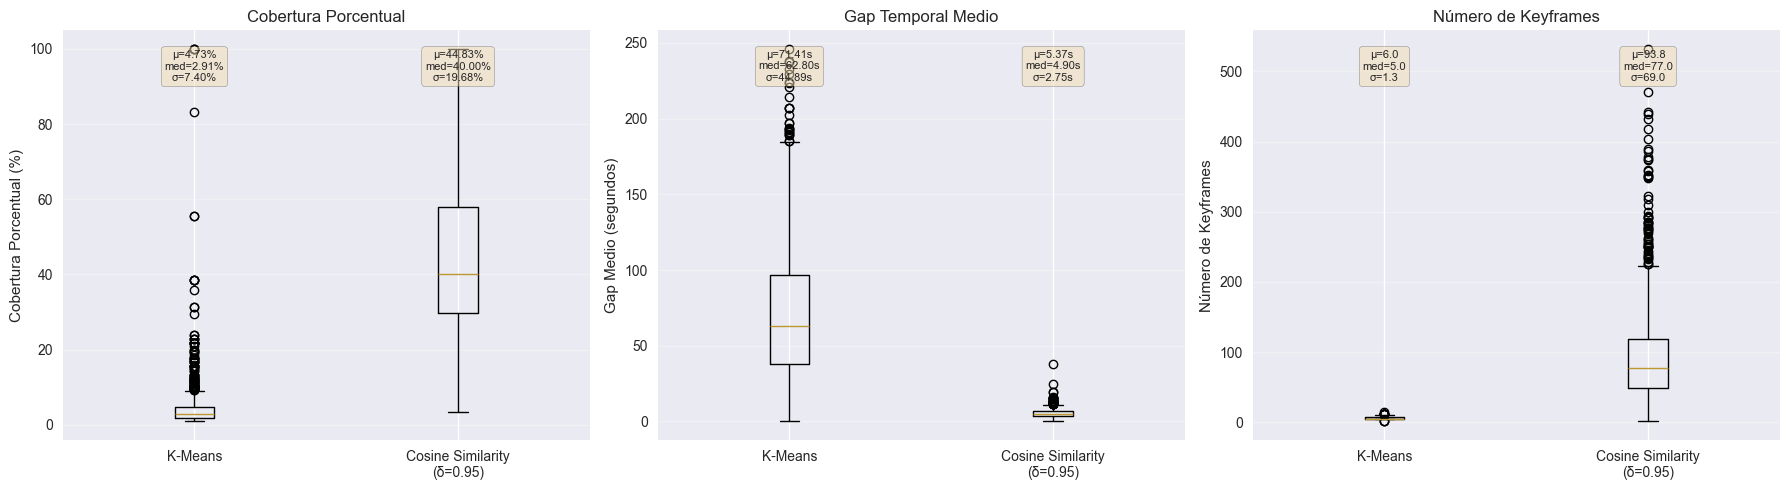

In [7]:
# Cargar métricas de ambos métodos
datasets_dir = project_root / "src" / "notebooks" / "datasets"

# Cargar métricas de K-Means
df_kmeans = pd.read_csv(datasets_dir / "metricas_cobertura_temporal_kmeans.csv")
df_kmeans['method'] = 'K-Means'

# Cargar métricas de Cosine Similarity
df_cosine = pd.read_csv(datasets_dir / "metricas_cobertura_temporal_cosine_similarity_threshold0.95.csv")
df_cosine['method'] = 'Cosine Similarity (δ=0.95)'

print("✅ Métricas cargadas:")
print(f"   • K-Means: {len(df_kmeans)} videos")
print(f"   • Cosine Similarity: {len(df_cosine)} videos")

# Combinar ambos dataframes para comparación
df_comparison = pd.concat([df_kmeans, df_cosine], ignore_index=True)

# Estadísticas comparativas
print("\n📊 COMPARACIÓN DE MÉTODOS")
print("=" * 80)

for method in df_comparison['method'].unique():
    method_data = df_comparison[df_comparison['method'] == method]
    print(f"\n{method}:")
    print(f"  • Cobertura:")
    print(f"    - Media: {method_data['coverage_percentage'].mean():.2f}%")
    print(f"    - Mediana: {method_data['coverage_percentage'].median():.2f}%")
    print(f"    - Desv. Estándar: {method_data['coverage_percentage'].std():.2f}%")
    print(f"  • Gap medio:")
    print(f"    - Media: {method_data['mean_gap'].mean():.2f}s")
    print(f"    - Mediana: {method_data['mean_gap'].median():.2f}s")
    print(f"    - Desv. Estándar: {method_data['mean_gap'].std():.2f}s")
    print(f"  • Keyframes:")
    print(f"    - Media: {method_data['n_keyframes'].mean():.1f}")
    print(f"    - Mediana: {method_data['n_keyframes'].median():.1f}")
    print(f"    - Desv. Estándar: {method_data['n_keyframes'].std():.1f}")
    print(f"  • Max gap: {method_data['max_gap'].max():.2f}s")
    print(f"  • Min gap: {method_data['min_gap'].min():.2f}s")

# Crear gráficos comparativos
fig = plt.figure(figsize=(20, 14))

# 1. Distribución de cobertura porcentual - Comparación
ax1 = plt.subplot(3, 3, 1)
colors = ['blue', 'orange']
for idx, method in enumerate(df_comparison['method'].unique()):
    method_data = df_comparison[df_comparison['method'] == method]
    mean_val = method_data['coverage_percentage'].mean()
    median_val = method_data['coverage_percentage'].median()
    std_val = method_data['coverage_percentage'].std()
    
    ax1.hist(method_data['coverage_percentage'], bins=30, alpha=0.6, label=method, 
             edgecolor='black', color=colors[idx])
    # Línea de media
    ax1.axvline(mean_val, color=colors[idx], linestyle='--', linewidth=2, 
                label=f'{method[:8]}... μ={mean_val:.2f}%')
    # Línea de mediana
    ax1.axvline(median_val, color=colors[idx], linestyle=':', linewidth=2, 
                label=f'{method[:8]}... med={median_val:.2f}%')
    # Líneas de desviación estándar
    ax1.axvline(mean_val - std_val, color=colors[idx], linestyle='-.', linewidth=1, alpha=0.5)
    ax1.axvline(mean_val + std_val, color=colors[idx], linestyle='-.', linewidth=1, alpha=0.5)
ax1.set_xlabel('Cobertura Porcentual (%)')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Cobertura Porcentual')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# 2. Boxplot de cobertura por método
ax2 = plt.subplot(3, 3, 2)
df_comparison.boxplot(column='coverage_percentage', by='method', ax=ax2)
ax2.set_xlabel('Método')
ax2.set_ylabel('Cobertura Porcentual (%)')
ax2.set_title('Cobertura Porcentual por Método')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
plt.suptitle('')  # Eliminar título automático

# 3. Distribución de gaps medios - Comparación
ax3 = plt.subplot(3, 3, 3)
colors = ['blue', 'orange']
for idx, method in enumerate(df_comparison['method'].unique()):
    method_data = df_comparison[df_comparison['method'] == method]
    mean_val = method_data['mean_gap'].mean()
    median_val = method_data['mean_gap'].median()
    std_val = method_data['mean_gap'].std()
    
    ax3.hist(method_data['mean_gap'], bins=30, alpha=0.6, label=method, 
             edgecolor='black', color=colors[idx])
    # Línea de media
    ax3.axvline(mean_val, color=colors[idx], linestyle='--', linewidth=2, 
                label=f'{method[:8]}... μ={mean_val:.2f}s')
    # Línea de mediana
    ax3.axvline(median_val, color=colors[idx], linestyle=':', linewidth=2, 
                label=f'{method[:8]}... med={median_val:.2f}s')
    # Líneas de desviación estándar
    ax3.axvline(mean_val - std_val, color=colors[idx], linestyle='-.', linewidth=1, alpha=0.5)
    ax3.axvline(mean_val + std_val, color=colors[idx], linestyle='-.', linewidth=1, alpha=0.5)
ax3.set_xlabel('Gap Medio (segundos)')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Distribución de Gaps Temporales Medios')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Boxplot de gaps por método
ax4 = plt.subplot(3, 3, 4)
df_comparison.boxplot(column='mean_gap', by='method', ax=ax4)
ax4.set_xlabel('Método')
ax4.set_ylabel('Gap Medio (segundos)')
ax4.set_title('Gaps Temporales por Método')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
plt.suptitle('')  # Eliminar título automático

# 5. Distribución de número de keyframes - Comparación
ax5 = plt.subplot(3, 3, 5)
colors = ['blue', 'orange']
for idx, method in enumerate(df_comparison['method'].unique()):
    method_data = df_comparison[df_comparison['method'] == method]
    mean_val = method_data['n_keyframes'].mean()
    median_val = method_data['n_keyframes'].median()
    std_val = method_data['n_keyframes'].std()
    
    ax5.hist(method_data['n_keyframes'], bins=30, alpha=0.6, label=method, 
             edgecolor='black', color=colors[idx])
    # Línea de media
    ax5.axvline(mean_val, color=colors[idx], linestyle='--', linewidth=2, 
                label=f'{method[:8]}... μ={mean_val:.1f}')
    # Línea de mediana
    ax5.axvline(median_val, color=colors[idx], linestyle=':', linewidth=2, 
                label=f'{method[:8]}... med={median_val:.1f}')
    # Líneas de desviación estándar
    ax5.axvline(mean_val - std_val, color=colors[idx], linestyle='-.', linewidth=1, alpha=0.5)
    ax5.axvline(mean_val + std_val, color=colors[idx], linestyle='-.', linewidth=1, alpha=0.5)
ax5.set_xlabel('Número de Keyframes')
ax5.set_ylabel('Frecuencia')
ax5.set_title('Distribución de Número de Keyframes')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

# 6. Boxplot de número de keyframes por método
ax6 = plt.subplot(3, 3, 6)
df_comparison.boxplot(column='n_keyframes', by='method', ax=ax6)
ax6.set_xlabel('Método')
ax6.set_ylabel('Número de Keyframes')
ax6.set_title('Número de Keyframes por Método')
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right')
plt.suptitle('')  # Eliminar título automático

# 7. Cobertura vs Número de keyframes - Comparación
ax7 = plt.subplot(3, 3, 7)
for method in df_comparison['method'].unique():
    method_data = df_comparison[df_comparison['method'] == method]
    ax7.scatter(method_data['n_keyframes'], method_data['coverage_percentage'], 
                alpha=0.5, label=method, s=20)
ax7.set_xlabel('Número de Keyframes')
ax7.set_ylabel('Cobertura Porcentual (%)')
ax7.set_title('Cobertura vs Número de Keyframes')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Cobertura vs Gap medio - Comparación
ax8 = plt.subplot(3, 3, 8)
for method in df_comparison['method'].unique():
    method_data = df_comparison[df_comparison['method'] == method]
    ax8.scatter(method_data['mean_gap'], method_data['coverage_percentage'], 
                alpha=0.5, label=method, s=20)
ax8.set_xlabel('Gap Medio (segundos)')
ax8.set_ylabel('Cobertura Porcentual (%)')
ax8.set_title('Cobertura vs Gap Medio')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Comparación de estadísticas resumidas
ax9 = plt.subplot(3, 3, 9)
metrics_to_compare = ['coverage_percentage', 'mean_gap', 'n_keyframes']
methods = df_comparison['method'].unique()
x = np.arange(len(metrics_to_compare))
width = 0.35

# Normalizar valores para comparación (usar valores relativos)
kmeans_means = [
    df_kmeans['coverage_percentage'].mean(),
    df_kmeans['mean_gap'].mean(),
    df_kmeans['n_keyframes'].mean()
]
cosine_means = [
    df_cosine['coverage_percentage'].mean(),
    df_cosine['mean_gap'].mean(),
    df_cosine['n_keyframes'].mean()
]

# Normalizar para que todos estén en escala 0-1 para visualización
kmeans_norm = [
    kmeans_means[0] / max(kmeans_means[0], cosine_means[0]),
    kmeans_means[1] / max(kmeans_means[1], cosine_means[1]),
    kmeans_means[2] / max(kmeans_means[2], cosine_means[2])
]
cosine_norm = [
    cosine_means[0] / max(kmeans_means[0], cosine_means[0]),
    cosine_means[1] / max(kmeans_means[1], cosine_means[1]),
    cosine_means[2] / max(kmeans_means[2], cosine_means[2])
]

ax9.bar(x - width/2, kmeans_norm, width, label='K-Means', alpha=0.8)
ax9.bar(x + width/2, cosine_norm, width, label='Cosine Similarity', alpha=0.8)
ax9.set_ylabel('Valor Normalizado')
ax9.set_title('Comparación Normalizada de Métricas')
ax9.set_xticks(x)
ax9.set_xticklabels(['Cobertura\n(%)', 'Gap Medio\n(s)', 'N° Keyframes'])
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Guardar visualización comparativa
output_img = project_root / "src" / "notebooks" / "images" / "cobertura_temporal_comparacion_completa.png"
output_img.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_img, dpi=300, bbox_inches='tight')
print(f"\n✅ Comparación completa guardada en: {output_img}")

plt.show()

# Crear gráfico adicional: Comparación lado a lado de métricas principales
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))

# Cobertura porcentual
bp1 = axes2[0].boxplot([df_kmeans['coverage_percentage'], df_cosine['coverage_percentage']], 
                       labels=['K-Means', 'Cosine Similarity\n(δ=0.95)'])
axes2[0].set_ylabel('Cobertura Porcentual (%)')
axes2[0].set_title('Cobertura Porcentual')
axes2[0].grid(True, alpha=0.3, axis='y')

# Agregar anotaciones con estadísticas
kmeans_cov_mean = df_kmeans['coverage_percentage'].mean()
kmeans_cov_median = df_kmeans['coverage_percentage'].median()
kmeans_cov_std = df_kmeans['coverage_percentage'].std()
cosine_cov_mean = df_cosine['coverage_percentage'].mean()
cosine_cov_median = df_cosine['coverage_percentage'].median()
cosine_cov_std = df_cosine['coverage_percentage'].std()

axes2[0].text(1, axes2[0].get_ylim()[1] * 0.95, 
              f'μ={kmeans_cov_mean:.2f}%\nmed={kmeans_cov_median:.2f}%\nσ={kmeans_cov_std:.2f}%',
              ha='center', va='top', fontsize=8, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes2[0].text(2, axes2[0].get_ylim()[1] * 0.95, 
              f'μ={cosine_cov_mean:.2f}%\nmed={cosine_cov_median:.2f}%\nσ={cosine_cov_std:.2f}%',
              ha='center', va='top', fontsize=8, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Gap medio
bp2 = axes2[1].boxplot([df_kmeans['mean_gap'], df_cosine['mean_gap']], 
                      labels=['K-Means', 'Cosine Similarity\n(δ=0.95)'])
axes2[1].set_ylabel('Gap Medio (segundos)')
axes2[1].set_title('Gap Temporal Medio')
axes2[1].grid(True, alpha=0.3, axis='y')

# Agregar anotaciones con estadísticas
kmeans_gap_mean = df_kmeans['mean_gap'].mean()
kmeans_gap_median = df_kmeans['mean_gap'].median()
kmeans_gap_std = df_kmeans['mean_gap'].std()
cosine_gap_mean = df_cosine['mean_gap'].mean()
cosine_gap_median = df_cosine['mean_gap'].median()
cosine_gap_std = df_cosine['mean_gap'].std()

axes2[1].text(1, axes2[1].get_ylim()[1] * 0.95, 
              f'μ={kmeans_gap_mean:.2f}s\nmed={kmeans_gap_median:.2f}s\nσ={kmeans_gap_std:.2f}s',
              ha='center', va='top', fontsize=8, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes2[1].text(2, axes2[1].get_ylim()[1] * 0.95, 
              f'μ={cosine_gap_mean:.2f}s\nmed={cosine_gap_median:.2f}s\nσ={cosine_gap_std:.2f}s',
              ha='center', va='top', fontsize=8, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Número de keyframes
bp3 = axes2[2].boxplot([df_kmeans['n_keyframes'], df_cosine['n_keyframes']], 
                      labels=['K-Means', 'Cosine Similarity\n(δ=0.95)'])
axes2[2].set_ylabel('Número de Keyframes')
axes2[2].set_title('Número de Keyframes')
axes2[2].grid(True, alpha=0.3, axis='y')

# Agregar anotaciones con estadísticas
kmeans_kf_mean = df_kmeans['n_keyframes'].mean()
kmeans_kf_median = df_kmeans['n_keyframes'].median()
kmeans_kf_std = df_kmeans['n_keyframes'].std()
cosine_kf_mean = df_cosine['n_keyframes'].mean()
cosine_kf_median = df_cosine['n_keyframes'].median()
cosine_kf_std = df_cosine['n_keyframes'].std()

axes2[2].text(1, axes2[2].get_ylim()[1] * 0.95, 
              f'μ={kmeans_kf_mean:.1f}\nmed={kmeans_kf_median:.1f}\nσ={kmeans_kf_std:.1f}',
              ha='center', va='top', fontsize=8, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes2[2].text(2, axes2[2].get_ylim()[1] * 0.95, 
              f'μ={cosine_kf_mean:.1f}\nmed={cosine_kf_median:.1f}\nσ={cosine_kf_std:.1f}',
              ha='center', va='top', fontsize=8, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()

# Guardar comparación simplificada
output_img2 = project_root / "src" / "notebooks" / "images" / "cobertura_temporal_comparacion_boxplot.png"
plt.savefig(output_img2, dpi=300, bbox_inches='tight')
print(f"✅ Comparación boxplot guardada en: {output_img2}")

plt.show()


## 6. Tabla Comparativa: Compresión y Cobertura Temporal

Tabla comparativa completa entre K-Means y Cosine Similarity en términos de compresión y cobertura temporal.


In [ ]:
# Crear tabla comparativa completa de compresión y cobertura temporal
import pandas as pd
from IPython.display import display, HTML

# Cargar métricas de cobertura temporal (ya calculadas)
print("📊 Creando tabla comparativa de compresión y cobertura temporal...")
print("=" * 80)

# Calcular métricas de compresión desde los datos de cobertura temporal
# La compresión se calcula como: (1 - n_keyframes/n_total_frames) * 100

# Para K-Means
df_kmeans_compression = df_kmeans.copy()
df_kmeans_compression['compression_ratio'] = (1 - df_kmeans_compression['n_keyframes'] / df_kmeans_compression['n_total_frames']) * 100

# Para Cosine Similarity
df_cosine_compression = df_cosine.copy()
df_cosine_compression['compression_ratio'] = (1 - df_cosine_compression['n_keyframes'] / df_cosine_compression['n_total_frames']) * 100

# Crear tabla comparativa
comparison_table = {
    'Métrica': [
        '**Compresión**',
        '  • Ratio de compresión promedio (%)',
        '  • Ratio de compresión mediana (%)',
        '  • Desviación estándar (%)',
        '  • Mínimo (%)',
        '  • Máximo (%)',
        '',
        '**Cobertura Temporal**',
        '  • Cobertura porcentual promedio (%)',
        '  • Cobertura porcentual mediana (%)',
        '  • Desviación estándar (%)',
        '  • Mínimo (%)',
        '  • Máximo (%)',
        '',
        '**Gaps Temporales**',
        '  • Gap medio promedio (s)',
        '  • Gap medio mediana (s)',
        '  • Desviación estándar (s)',
        '  • Gap máximo (s)',
        '  • Gap mínimo (s)',
        '',
        '**Keyframes**',
        '  • Número promedio de keyframes',
        '  • Número mediano de keyframes',
        '  • Desviación estándar',
        '  • Mínimo',
        '  • Máximo',
        '',
        '**Videos analizados**',
    ],
    'K-Means': [
        '',
        f"{df_kmeans_compression['compression_ratio'].mean():.2f}",
        f"{df_kmeans_compression['compression_ratio'].median():.2f}",
        f"{df_kmeans_compression['compression_ratio'].std():.2f}",
        f"{df_kmeans_compression['compression_ratio'].min():.2f}",
        f"{df_kmeans_compression['compression_ratio'].max():.2f}",
        '',
        '',
        f"{df_kmeans['coverage_percentage'].mean():.2f}",
        f"{df_kmeans['coverage_percentage'].median():.2f}",
        f"{df_kmeans['coverage_percentage'].std():.2f}",
        f"{df_kmeans['coverage_percentage'].min():.2f}",
        f"{df_kmeans['coverage_percentage'].max():.2f}",
        '',
        '',
        f"{df_kmeans['mean_gap'].mean():.2f}",
        f"{df_kmeans['mean_gap'].median():.2f}",
        f"{df_kmeans['mean_gap'].std():.2f}",
        f"{df_kmeans['max_gap'].max():.2f}",
        f"{df_kmeans['min_gap'].min():.2f}",
        '',
        '',
        f"{df_kmeans['n_keyframes'].mean():.1f}",
        f"{df_kmeans['n_keyframes'].median():.1f}",
        f"{df_kmeans['n_keyframes'].std():.1f}",
        f"{df_kmeans['n_keyframes'].min():.0f}",
        f"{df_kmeans['n_keyframes'].max():.0f}",
        '',
        f"{len(df_kmeans)}",
    ],
    'Cosine Similarity (δ=0.95)': [
        '',
        f"{df_cosine_compression['compression_ratio'].mean():.2f}",
        f"{df_cosine_compression['compression_ratio'].median():.2f}",
        f"{df_cosine_compression['compression_ratio'].std():.2f}",
        f"{df_cosine_compression['compression_ratio'].min():.2f}",
        f"{df_cosine_compression['compression_ratio'].max():.2f}",
        '',
        '',
        f"{df_cosine['coverage_percentage'].mean():.2f}",
        f"{df_cosine['coverage_percentage'].median():.2f}",
        f"{df_cosine['coverage_percentage'].std():.2f}",
        f"{df_cosine['coverage_percentage'].min():.2f}",
        f"{df_cosine['coverage_percentage'].max():.2f}",
        '',
        '',
        f"{df_cosine['mean_gap'].mean():.2f}",
        f"{df_cosine['mean_gap'].median():.2f}",
        f"{df_cosine['mean_gap'].std():.2f}",
        f"{df_cosine['max_gap'].max():.2f}",
        f"{df_cosine['min_gap'].min():.2f}",
        '',
        '',
        f"{df_cosine['n_keyframes'].mean():.1f}",
        f"{df_cosine['n_keyframes'].median():.1f}",
        f"{df_cosine['n_keyframes'].std():.1f}",
        f"{df_cosine['n_keyframes'].min():.0f}",
        f"{df_cosine['n_keyframes'].max():.0f}",
        '',
        f"{len(df_cosine)}",
    ]
}

df_comparison_table = pd.DataFrame(comparison_table)

# Crear tabla HTML formateada
html_table = """
<style>
.comparison-table {
    border-collapse: collapse;
    margin: 20px 0;
    font-size: 14px;
    font-family: Arial, sans-serif;
    width: 100%;
    box-shadow: 0 2px 8px rgba(0,0,0,0.1);
}
.comparison-table th {
    background-color: #4a90e2;
    color: white;
    padding: 12px 15px;
    text-align: left;
    font-weight: bold;
    border: 1px solid #ddd;
}
.comparison-table td {
    padding: 10px 15px;
    border: 1px solid #ddd;
}
.comparison-table tr:nth-child(even) {
    background-color: #f9f9f9;
}
.comparison-table tr:hover {
    background-color: #f5f5f5;
}
.comparison-table .metric-header {
    background-color: #2c3e50;
    color: white;
    font-weight: bold;
    font-size: 15px;
}
.comparison-table .metric-subheader {
    background-color: #ecf0f1;
    font-weight: 600;
    padding-left: 20px;
}
</style>
"""

html_table += "<table class='comparison-table'>\n"
html_table += "<thead>\n<tr>\n"
html_table += "<th>Métrica</th>\n"
html_table += "<th>K-Means</th>\n"
html_table += "<th>Cosine Similarity (δ=0.95)</th>\n"
html_table += "</tr>\n</thead>\n<tbody>\n"

for idx, row in df_comparison_table.iterrows():
    metric = row['Métrica']
    kmeans_val = row['K-Means']
    cosine_val = row['Cosine Similarity (δ=0.95)']
    
    # Determinar clase CSS
    if metric.startswith('**') and metric.endswith('**'):
        css_class = "metric-header"
        metric_text = metric.replace('**', '')
    elif metric.startswith('  •'):
        css_class = "metric-subheader"
        metric_text = metric
    else:
        css_class = ""
        metric_text = metric
    
    html_table += f"<tr class='{css_class}'>\n"
    html_table += f"<td>{metric_text}</td>\n"
    html_table += f"<td>{kmeans_val}</td>\n"
    html_table += f"<td>{cosine_val}</td>\n"
    html_table += "</tr>\n"

html_table += "</tbody>\n</table>"

# Mostrar tabla HTML
display(HTML(html_table))

# También mostrar como DataFrame para copiar
print("\n📋 Tabla en formato DataFrame (para copiar):")
print("=" * 80)
print(df_comparison_table.to_string(index=False))

# Guardar tabla como CSV
output_table_path = project_root / "src" / "notebooks" / "datasets" / "tabla_comparativa_compresion_cobertura.csv"
df_comparison_table.to_csv(output_table_path, index=False)
print(f"\n✅ Tabla comparativa guardada en: {output_table_path}")

# Análisis de diferencias
print("\n📊 ANÁLISIS DE DIFERENCIAS:")
print("=" * 80)
print(f"Compresión:")
print(f"  • K-Means comprime {df_kmeans_compression['compression_ratio'].mean():.2f}% vs Cosine Similarity {df_cosine_compression['compression_ratio'].mean():.2f}%")
print(f"  • Diferencia: {df_kmeans_compression['compression_ratio'].mean() - df_cosine_compression['compression_ratio'].mean():.2f} puntos porcentuales")
print(f"  • K-Means comprime {'más' if df_kmeans_compression['compression_ratio'].mean() > df_cosine_compression['compression_ratio'].mean() else 'menos'} que Cosine Similarity")

print(f"\nCobertura Temporal:")
print(f"  • K-Means cubre {df_kmeans['coverage_percentage'].mean():.2f}% vs Cosine Similarity {df_cosine['coverage_percentage'].mean():.2f}%")
print(f"  • Diferencia: {df_cosine['coverage_percentage'].mean() - df_kmeans['coverage_percentage'].mean():.2f} puntos porcentuales")
print(f"  • Cosine Similarity cubre {'más' if df_cosine['coverage_percentage'].mean() > df_kmeans['coverage_percentage'].mean() else 'menos'} tiempo que K-Means")

print(f"\nGaps Temporales:")
print(f"  • K-Means gap medio: {df_kmeans['mean_gap'].mean():.2f}s vs Cosine Similarity {df_cosine['mean_gap'].mean():.2f}s")
print(f"  • Diferencia: {df_kmeans['mean_gap'].mean() - df_cosine['mean_gap'].mean():.2f}s")
print(f"  • K-Means tiene gaps {'mayores' if df_kmeans['mean_gap'].mean() > df_cosine['mean_gap'].mean() else 'menores'} que Cosine Similarity")

print(f"\nNúmero de Keyframes:")
print(f"  • K-Means: {df_kmeans['n_keyframes'].mean():.1f} keyframes promedio")
print(f"  • Cosine Similarity: {df_cosine['n_keyframes'].mean():.1f} keyframes promedio")
print(f"  • Ratio: Cosine Similarity selecciona {df_cosine['n_keyframes'].mean() / df_kmeans['n_keyframes'].mean():.1f}x más keyframes que K-Means")


📊 Creando tabla comparativa de compresión y cobertura temporal...


Métrica,K-Means,Cosine Similarity (δ=0.95)
Compresión,,
• Ratio de compresión promedio (%),95.27,55.17
• Ratio de compresión mediana (%),97.09,60.00
• Desviación estándar (%),7.40,19.68
• Mínimo (%),0.00,0.00
• Máximo (%),99.14,96.67
,,
Cobertura Temporal,,
• Cobertura porcentual promedio (%),4.73,44.83
• Cobertura porcentual mediana (%),2.91,40.00



📋 Tabla en formato DataFrame (para copiar):
                              Métrica K-Means Cosine Similarity (δ=0.95)
                       **Compresión**                                   
   • Ratio de compresión promedio (%)   95.27                      55.17
    • Ratio de compresión mediana (%)   97.09                      60.00
            • Desviación estándar (%)    7.40                      19.68
                         • Mínimo (%)    0.00                       0.00
                         • Máximo (%)   99.14                      96.67
                                                                        
               **Cobertura Temporal**                                   
  • Cobertura porcentual promedio (%)    4.73                      44.83
   • Cobertura porcentual mediana (%)    2.91                      40.00
            • Desviación estándar (%)    7.40                      19.68
                         • Mínimo (%)    0.86                       3.33
      

## 7. Tabla Comparativa Resumida (Solo Promedios)

Tabla resumida con los valores promedio de las métricas principales.


In [ ]:
# Crear tabla comparativa resumida (solo promedios)
print("📊 Creando tabla comparativa resumida (solo promedios)...")
print("=" * 80)

# Calcular métricas de compresión
df_kmeans_compression = df_kmeans.copy()
df_kmeans_compression['compression_ratio'] = (1 - df_kmeans_compression['n_keyframes'] / df_kmeans_compression['n_total_frames']) * 100

df_cosine_compression = df_cosine.copy()
df_cosine_compression['compression_ratio'] = (1 - df_cosine_compression['n_keyframes'] / df_cosine_compression['n_total_frames']) * 100

# Crear tabla resumida con solo promedios y descripciones
summary_table = {
    'Métrica': [
        'Ratio de Compresión Promedio (%)',
        'Cobertura Temporal Promedio (%)',
        'Gap Medio Promedio (segundos)',
        'Número Promedio de Keyframes',
        'Videos Analizados'
    ],
    'Descripción': [
        'Porcentaje de frames eliminados. Mide cuánto se reduce el video (mayor = más compresión)',
        'Porcentaje del tiempo total del video cubierto por keyframes (mayor = mejor cobertura)',
        'Tiempo promedio entre keyframes consecutivos (menor = keyframes más cercanos)',
        'Cantidad promedio de keyframes seleccionados por video',
        'Número total de videos procesados con cada método'
    ],
    'K-Means': [
        f"{df_kmeans_compression['compression_ratio'].mean():.2f}",
        f"{df_kmeans['coverage_percentage'].mean():.2f}",
        f"{df_kmeans['mean_gap'].mean():.2f}",
        f"{df_kmeans['n_keyframes'].mean():.1f}",
        f"{len(df_kmeans)}"
    ],
    'Cosine Similarity (δ=0.95)': [
        f"{df_cosine_compression['compression_ratio'].mean():.2f}",
        f"{df_cosine['coverage_percentage'].mean():.2f}",
        f"{df_cosine['mean_gap'].mean():.2f}",
        f"{df_cosine['n_keyframes'].mean():.1f}",
        f"{len(df_cosine)}"
    ]
}

df_summary = pd.DataFrame(summary_table)

# Crear tabla HTML formateada (más simple)
html_summary = """
<style>
.summary-table {
    border-collapse: collapse;
    margin: 20px 0;
    font-size: 15px;
    font-family: Arial, sans-serif;
    width: 100%;
    max-width: 1000px;
    box-shadow: 0 2px 8px rgba(0,0,0,0.1);
}
.summary-table th {
    background-color: #4a90e2;
    color: white;
    padding: 15px 20px;
    text-align: left;
    font-weight: bold;
    border: 1px solid #ddd;
    font-size: 16px;
}
.summary-table td {
    padding: 12px 20px;
    border: 1px solid #ddd;
}
.summary-table tr:nth-child(even) {
    background-color: #f9f9f9;
}
.summary-table tr:hover {
    background-color: #f5f5f5;
}
.summary-table .metric-name {
    font-weight: 600;
    color: #2c3e50;
}
</style>
"""

html_summary += "<table class='summary-table'>\n"
html_summary += "<thead>\n<tr>\n"
html_summary += "<th>Métrica</th>\n"
html_summary += "<th>Descripción</th>\n"
html_summary += "<th>K-Means</th>\n"
html_summary += "<th>Cosine Similarity (δ=0.95)</th>\n"
html_summary += "</tr>\n</thead>\n<tbody>\n"

for idx, row in df_summary.iterrows():
    metric = row['Métrica']
    description = row['Descripción']
    kmeans_val = row['K-Means']
    cosine_val = row['Cosine Similarity (δ=0.95)']
    
    html_summary += "<tr>\n"
    html_summary += f"<td class='metric-name'>{metric}</td>\n"
    html_summary += f"<td style='font-size: 13px; color: #555;'>{description}</td>\n"
    html_summary += f"<td>{kmeans_val}</td>\n"
    html_summary += f"<td>{cosine_val}</td>\n"
    html_summary += "</tr>\n"

html_summary += "</tbody>\n</table>"

# Mostrar tabla HTML
display(HTML(html_summary))

# También mostrar como DataFrame
print("\n📋 Tabla resumida en formato DataFrame:")
print("=" * 80)
print(df_summary.to_string(index=False))

# Guardar tabla resumida como CSV
output_summary_path = project_root / "src" / "notebooks" / "datasets" / "tabla_comparativa_resumida.csv"
df_summary.to_csv(output_summary_path, index=False)
print(f"\n✅ Tabla resumida guardada en: {output_summary_path}")

# Mostrar diferencias clave
print("\n📊 RESUMEN DE DIFERENCIAS:")
print("=" * 80)
comp_diff = df_kmeans_compression['compression_ratio'].mean() - df_cosine_compression['compression_ratio'].mean()
coverage_diff = df_cosine['coverage_percentage'].mean() - df_kmeans['coverage_percentage'].mean()
gap_diff = df_kmeans['mean_gap'].mean() - df_cosine['mean_gap'].mean()
kf_ratio = df_cosine['n_keyframes'].mean() / df_kmeans['n_keyframes'].mean()

print(f"• Compresión: K-Means comprime {comp_diff:.2f} puntos porcentuales más que Cosine Similarity")
print(f"• Cobertura: Cosine Similarity cubre {coverage_diff:.2f} puntos porcentuales más que K-Means")
print(f"• Gaps: K-Means tiene gaps {gap_diff:.2f}s mayores que Cosine Similarity")
print(f"• Keyframes: Cosine Similarity selecciona {kf_ratio:.1f}x más keyframes que K-Means")


📊 Creando tabla comparativa resumida (solo promedios)...


Métrica,Descripción,K-Means,Cosine Similarity (δ=0.95)
Ratio de Compresión Promedio (%),Porcentaje de frames eliminados. Mide cuánto se reduce el video (mayor = más compresión),95.27,55.17
Cobertura Temporal Promedio (%),Porcentaje del tiempo total del video cubierto por keyframes (mayor = mejor cobertura),4.73,44.83
Gap Medio Promedio (segundos),Tiempo promedio entre keyframes consecutivos (menor = keyframes más cercanos),71.41,5.37
Número Promedio de Keyframes,Cantidad promedio de keyframes seleccionados por video,6.0,93.8
Videos Analizados,Número total de videos procesados con cada método,1131,1133



📋 Tabla resumida en formato DataFrame:
                         Métrica                                                                              Descripción K-Means Cosine Similarity (δ=0.95)
Ratio de Compresión Promedio (%) Porcentaje de frames eliminados. Mide cuánto se reduce el video (mayor = más compresión)   95.27                      55.17
 Cobertura Temporal Promedio (%)   Porcentaje del tiempo total del video cubierto por keyframes (mayor = mejor cobertura)    4.73                      44.83
   Gap Medio Promedio (segundos)            Tiempo promedio entre keyframes consecutivos (menor = keyframes más cercanos)   71.41                       5.37
    Número Promedio de Keyframes                                   Cantidad promedio de keyframes seleccionados por video     6.0                       93.8
               Videos Analizados                                        Número total de videos procesados con cada método    1131                       1133

✅ Tabla resumida 